# Super restriction factor hypermutation analysis
### Adam S. Dingens
### In collabortation with Mollie McDonnell and Michael Emerman

Analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. Cell culture experiments performed by Mollie McDonnell, and sequencing prep performed by Mollie with Adam's guidance.

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [3]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np
import pylab as plt


print("Using dms_tools2 version {0}".format(dms_tools2.__version__))


# results will go in this directory
resultsdir = './results_1and1b/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 14

# do we use existing results or generate everything new?
use_existing = "no"

Using dms_tools2 version 2.6.4


In [2]:
from dms_tools2.utils import barcodeInfoToCodonVariantTable
from dms_tools2.utils import getSubstitutions
import re
import tempfile
import dms_variants.codonvarianttable
import gzip

# Download the sequencing data from the Sequence Read Archive
UPDATE LATER

samples = pd.DataFrame.from_records(
#new data published here for 1-18
        [('BG505_mut_virus_rep3d_1-18-4ug','SRR10014244'),
         ('BG505_mut_virus_rep3d_1-18-8ug','SRR10014243'),
         ('BG505_mut_virus_rep2d_1-18-4ug','SRR10014242'),
         ('BG505_mut_virus_rep2d_1-18-8ug','SRR10014241'),
         ('BG505_mut_virus_rep2d','SRR10014240'),
         ('BG505_mut_virus_rep3d','SRR10014239'),
#Data on VRC01 and 3BNC117 from Dingens et al Immunity 2019 
#Here, I do not download the data on 10-1074 and pooled 10-1074/3BNC117. While I look at this data briefly for one analysis, I simply download the analyzed files from github rather than redoing all analyses. However these can be downloaded and anaylzed in parallel by uncommentin the relevant lines below. 
         ('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),

         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),

         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep1','SRR7693987')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

## Define samples from FASTQ_files

R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [3]:
samplenames = ["PLASMIDCTRL", "NoA3_1", "A3G_1", "A3C_1", "A3CE68A_1", "COTD_1", "COTDE254A_1", "COTDE68AE254A_1", "I188_1", "I188E68A_1", "COII_1", "COIIE68AE254A_1", "NoA3_2", "A3G_2", "A3C_2", "A3CE68A_2", "COTD_2", "COTDE254A_2", "COTDE68AE254A_2", "I188_2", "I188E68A_2", "COII_2", "COIIE68AE254A_2"]
R1_df = pd.DataFrame({'name':samplenames})

R1_df["name"] = R1_df['name'].str.replace("_", "-")
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
print(R1_df)

               name                           R1
0       PLASMIDCTRL      PLASMIDCTRL_R1.fastq.gz
1            NoA3-1           NoA3-1_R1.fastq.gz
2             A3G-1            A3G-1_R1.fastq.gz
3             A3C-1            A3C-1_R1.fastq.gz
4         A3CE68A-1        A3CE68A-1_R1.fastq.gz
5            COTD-1           COTD-1_R1.fastq.gz
6       COTDE254A-1      COTDE254A-1_R1.fastq.gz
7   COTDE68AE254A-1  COTDE68AE254A-1_R1.fastq.gz
8            I188-1           I188-1_R1.fastq.gz
9        I188E68A-1       I188E68A-1_R1.fastq.gz
10           COII-1           COII-1_R1.fastq.gz
11  COIIE68AE254A-1  COIIE68AE254A-1_R1.fastq.gz
12           NoA3-2           NoA3-2_R1.fastq.gz
13            A3G-2            A3G-2_R1.fastq.gz
14            A3C-2            A3C-2_R1.fastq.gz
15        A3CE68A-2        A3CE68A-2_R1.fastq.gz
16           COTD-2           COTD-2_R1.fastq.gz
17      COTDE254A-2      COTDE254A-2_R1.fastq.gz
18  COTDE68AE254A-2  COTDE68AE254A-2_R1.fastq.gz
19           I188-2 

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [4]:
!pwd


/fh/fast/bloom_j/computational_notebooks/adingens/2019/SuperRes_Hypermut


In [5]:
#first, initial fastqdir ='../../../../SR/ngs/illumina/bloom_lab/190913_M03100_0478_000000000-CKT45/Data/Intensities/'
#these are in: "./FASTQ_files_initialMiseqOnly/"

#then the post rnd2 samples were repooled and sequenced again. These additional reads can thus simple be added to the existing reads. I did this by concatenating all reads from both runs into single fastq files, putting them in the same fastq file
#second miseq to be added with initial miseq run. These are in:
fastqdir = "./FASTQ_files/"


#Mollie also redid rnd2? and resquenced. These read CANNOT be added to the above reads before error correction, as molecules were tagged in spereate PCR rxns?
#however, in the future, the error corrected mutation counts could be summed together and then analyzed. 
#For now, I put these reads in a seperate fastqdir:
#miseq run: 191104_M04866_0302_000000000-CNB5P
#these are in: "./FASTQ_files_exp2/"


In [6]:
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) #was 204,504,34,34 #these need to be updated 179,529,25,25


# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PLASMIDCTRL,PLASMIDCTRL_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3C-1,A3C-1_R1.fastq.gz
A3CE68A-1,A3CE68A-1_R1.fastq.gz
COTD-1,COTD-1_R1.fastq.gz
COTDE254A-1,COTDE254A-1_R1.fastq.gz
COTDE68AE254A-1,COTDE68AE254A-1_R1.fastq.gz
I188-1,I188-1_R1.fastq.gz
I188E68A-1,I188E68A-1_R1.fastq.gz


In [7]:

#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 15 \
        --fastqdir {fastqdir} \
        --maxmuts 100 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

# need to edit



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [7]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

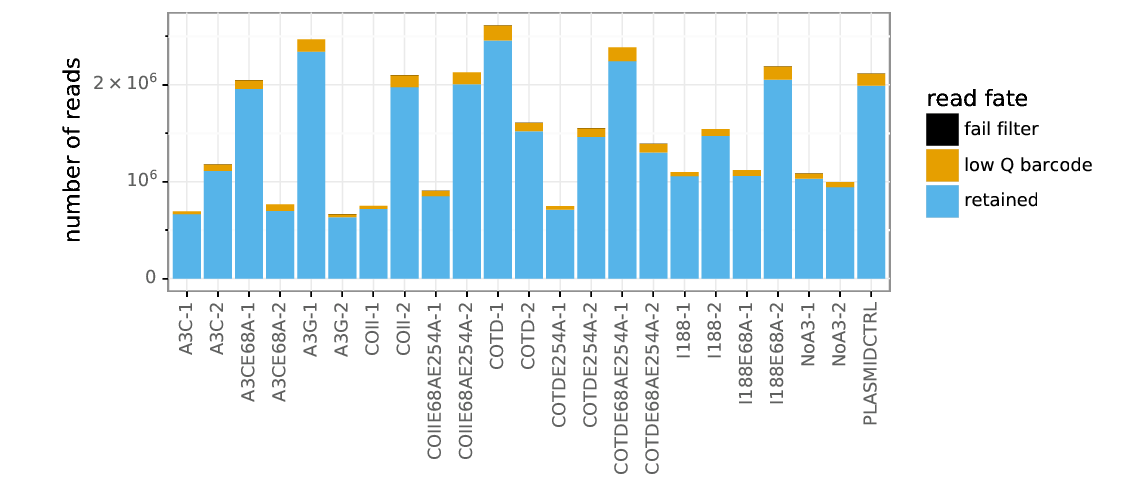

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

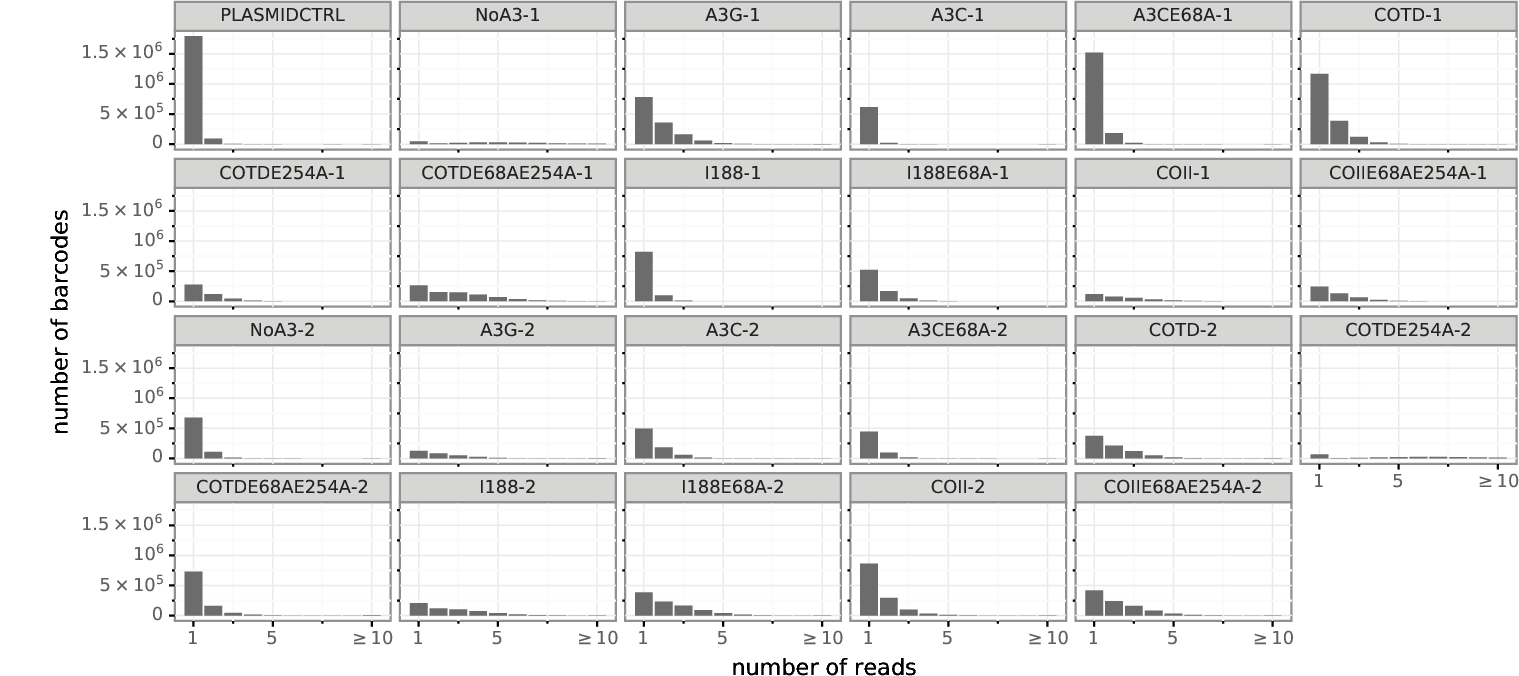

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

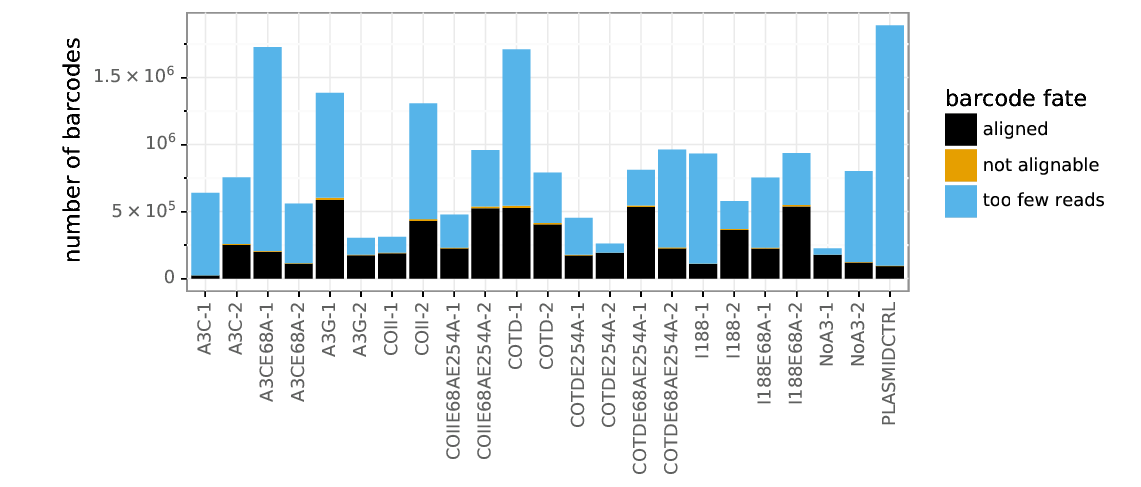

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

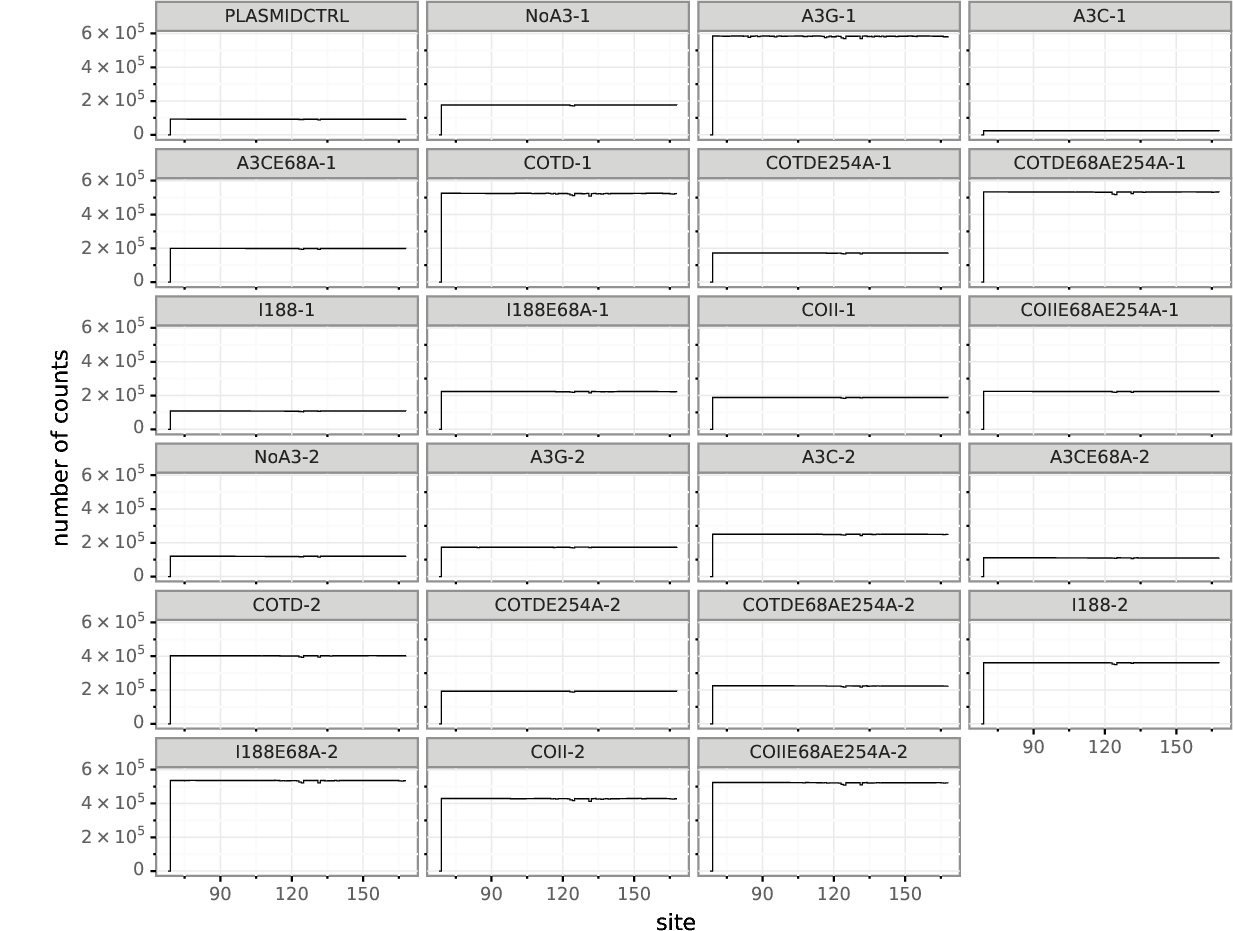

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

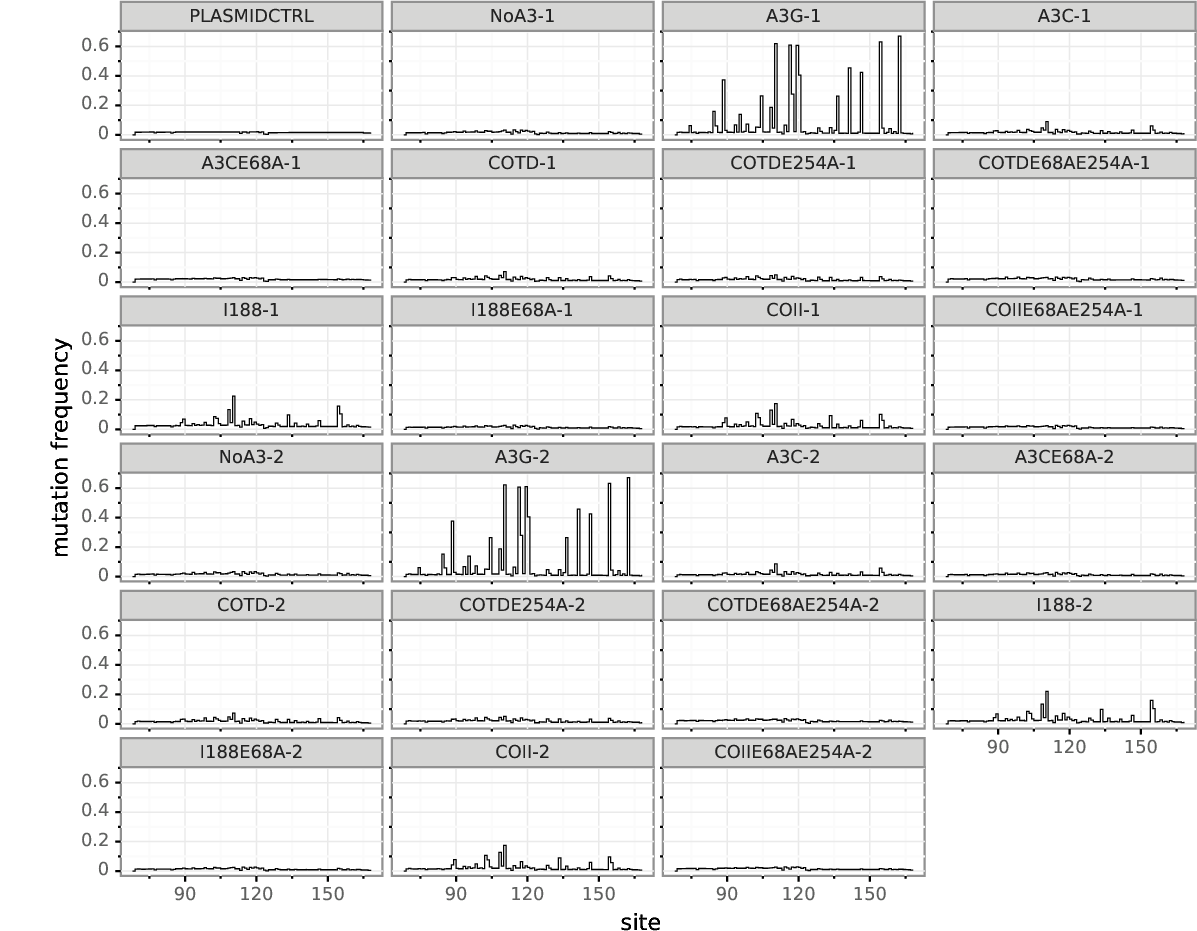

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

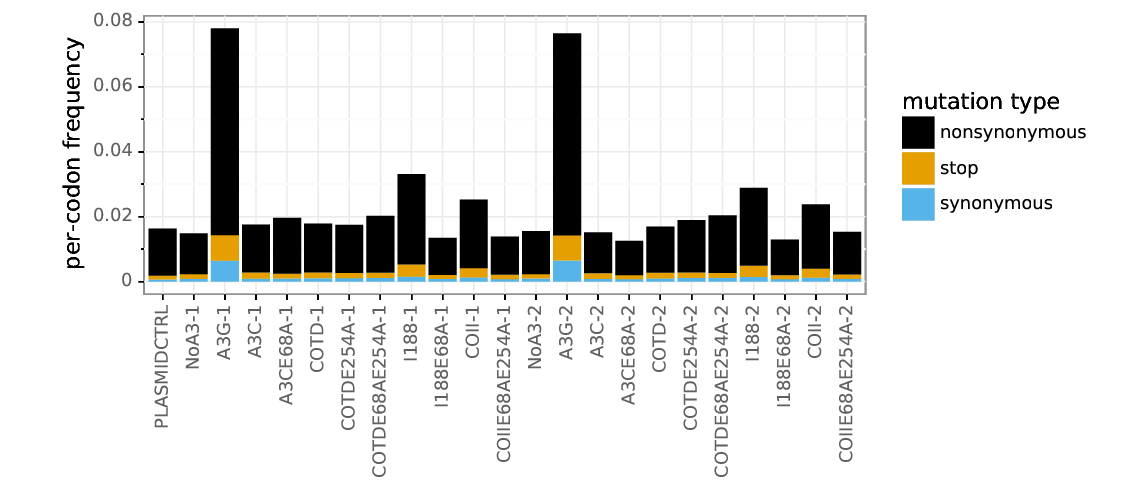

In [12]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

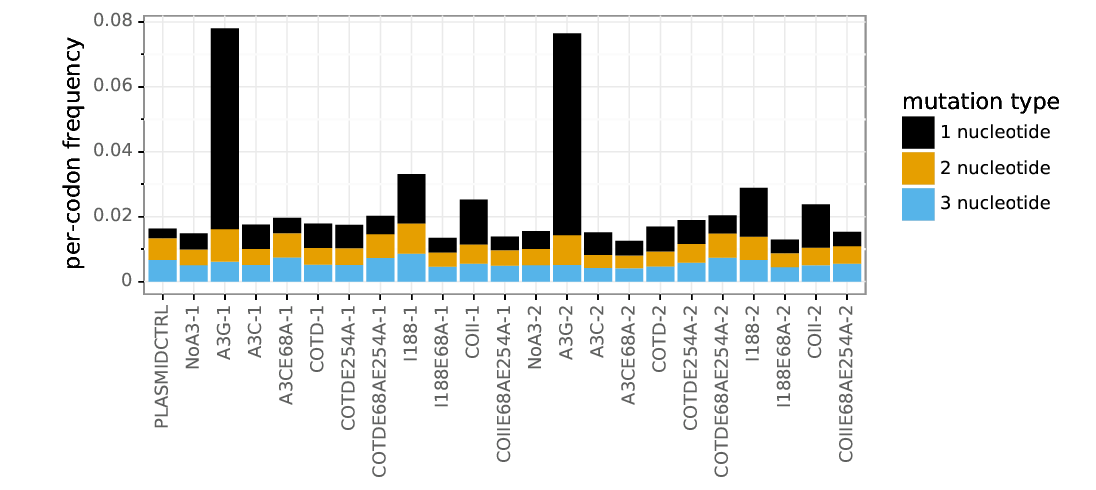

In [13]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

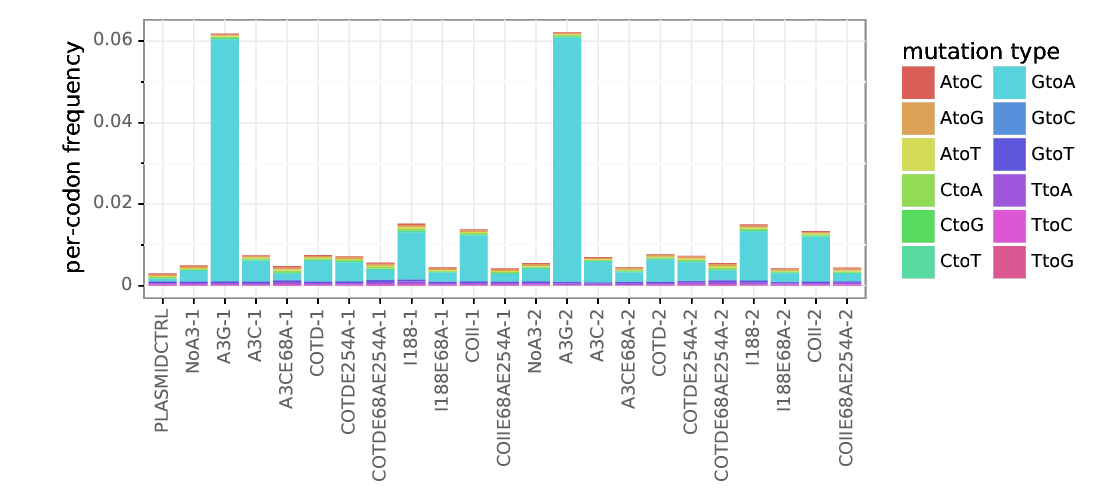

In [14]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Parse bcinfo files into codon variant tables
I will use [dms_tools2.utils.barcodeInfoToCodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.barcodeInfoToCodonVariantTable) to parse the /codoncounts/(sample)_bcinfo.txt.gz. files into codon variant tables. 


# New plan:
Alternatively, the /codoncounts/(sample)_bcinfo.txt.gz files (viewed at the end of this notebook) output by bcsubamp could be directly parsed using getSubstitions. 

In [14]:
samplenames2 = ["PLASMIDCTRL", "NoA3-1", "A3G-1", "A3C-1", "A3CE68A-1", "COTD-1", "COTDE254A-1", "COTDE68AE254A-1", "I188-1", "I188E68A-1", "COII-1", "COIIE68AE254A-1", "NoA3-2", "A3G-2", "A3C-2", "A3CE68A-2", "COTD-2", "COTDE254A-2", "COTDE68AE254A-2", "I188-2", "I188E68A-2", "COII-2", "COIIE68AE254A-2"]
samplebcinfofiles = []
for name in samplenames2:
    templist=[]
    templist.append("{0}/{1}".format(countsdir, name))
    samplebcinfofiles.append(templist)
bcinfo_dict = {}

# Create a zip object from two lists
zipbObj = zip(samplenames2, samplebcinfofiles)
 
# Create a dictionary from zip object
bcinfo_dict = dict(zipbObj)

bcinfo_dict

{'PLASMIDCTRL': ['./results_1and1b/codoncounts/PLASMIDCTRL'],
 'NoA3-1': ['./results_1and1b/codoncounts/NoA3-1'],
 'A3G-1': ['./results_1and1b/codoncounts/A3G-1'],
 'A3C-1': ['./results_1and1b/codoncounts/A3C-1'],
 'A3CE68A-1': ['./results_1and1b/codoncounts/A3CE68A-1'],
 'COTD-1': ['./results_1and1b/codoncounts/COTD-1'],
 'COTDE254A-1': ['./results_1and1b/codoncounts/COTDE254A-1'],
 'COTDE68AE254A-1': ['./results_1and1b/codoncounts/COTDE68AE254A-1'],
 'I188-1': ['./results_1and1b/codoncounts/I188-1'],
 'I188E68A-1': ['./results_1and1b/codoncounts/I188E68A-1'],
 'COII-1': ['./results_1and1b/codoncounts/COII-1'],
 'COIIE68AE254A-1': ['./results_1and1b/codoncounts/COIIE68AE254A-1'],
 'NoA3-2': ['./results_1and1b/codoncounts/NoA3-2'],
 'A3G-2': ['./results_1and1b/codoncounts/A3G-2'],
 'A3C-2': ['./results_1and1b/codoncounts/A3C-2'],
 'A3CE68A-2': ['./results_1and1b/codoncounts/A3CE68A-2'],
 'COTD-2': ['./results_1and1b/codoncounts/COTD-2'],
 'COTDE254A-2': ['./results_1and1b/codoncounts/C

In [23]:
#defining a new form of the function below that drops any conesnus sequences that do not match the length of the refseq.
#DO I NEED TO DO THIS?
def barcodeInfoToCodonVariantTable_dropIndels(samples, geneseq, path=None):
    """Convert barcode info files into a CodonVariantTable
    Convert barcode info files output from `dms2_bcsubamp` into a
    `CodonVariantTable`. Barcode info files contain reads and barcodes from
    barcoded subamplicon sequencing, described 
    `here <https://jbloomlab.github.io/dms_tools2/bcsubamp.html>`_.
    This function takes consensus reads retained by `dms2_bcsubamp`, 
    gives each unique sequence a numerical barcode (since the barcodes from 
    `dms2_bcsubamp` could come from the same variant), and counts the number
    of retained consensus reads corresponding to each sequence. Then, a
    `CodonVariantTable` is made using the sequences and their numerical 
    barcodes, and counts are added based on the number of retained consensus
    reads of those sequences. Therefore, the `CodonVariantTable` will only 
    contain one 'variant' for each unique sequence with the total count for all
    the unbarcoded variants in the experiment which had the same sequence.
    Args:
        `samples` (dict):
            Dictionary with libraries as keys and lists of info file prefixes
            (file names without the '_bcinfo.txt.gz') for files corresponding
            to those libraries as values.
            
            Example: {'library-1':['condition-1-library-1'],
                      'library-2':['condition-1-library-2']}
        `geneseq` (str):
            The wildtype gene sequence
        `path` (str)
            Directory in which barcode info files are located
    Returns:
        A `dms_variants.codonvarianttable.CodonVariantTable` with 'counts'
        generated from the barcode info files
    """

    # Set up re matchers for looking at lines
    matcher = re.compile(r'(?P<linetype>^.*\:) '
                         r'(?P<contents>.*$)')

    alt_matcher = re.compile(r'(?P<linetype>^R\d READS:$)')

    read_matcher = re.compile(r'(?P<read>^[ATGCN\s]*$)')

    # Create a dictionary to contain dictionaries of each library's barcodes
    libraries = {}

    # Initialize lists for making the codonvarianttable
    barcodes = []
    subs = []
    variant_call_support = []
    library_list = []

    # For each library, go through each sample file and collect data
    for library in samples.keys():
        # Initialize dictionary to contain this library's reads and barcodes
        barcode_dictionary = {}
        # Start a barcode count for this library
        cur_barcode = 1
        # For each barcode info file corresponding to a sample in this library
        for sample in samples[library]:

            # Set initial conditions
            take_next = False
            description_skipped = False
            
            indelcount = 0
            # Find the file
            f = f"{sample}_bcinfo.txt.gz"
            if path:
                file_path = os.path.join(os.path.abspath(path), f)
            else:
                file_path = f
            print(file_path)
            # Open the file and loop through it to find retained consensus
            # reads and give them each a new barcode
            with gzip.open(file_path, 'r') as f:
                # Make sure the first line looks like it is supposed to
                firstline = f.readline()
                firstline = firstline.decode()
                first_match = matcher.match(firstline)
                if first_match.group('linetype') != 'BARCODE:':
                    raise ValueError(f"Unexpected first line {firstline}: may be "
                    "unexpected file type")
                else:
                    previous_line = first_match

                # Go through the lines, making they are in the expected order
                for line in f:
                    line = line.decode()
                    line_match = matcher.match(line)
                    if not line_match:
                        line_match = alt_matcher.match(line)
                    if not line_match:
                        read_match = read_matcher.match(line)
                        if not read_match:
                            raise ValueError(f"Unable to recognize line {line}")
                        else:
                            line_is_read = True
                            previous_linetype = previous_line.group('linetype')
                            if previous_linetype != 'R1 READS:' and \
                               previous_linetype != 'R2 READS:':
                               raise ValueError(f"Unexpected line {line}")
                    else:
                        line_is_read = False
                    if previous_line.group('linetype') == 'BARCODE:':
                        if line_match.group('linetype') != 'RETAINED:':
                            raise ValueError(f"Unexpected line {line}")
                        # Decide whether to retain the next consensus or not
                        else:
                            if line_match.group('contents') == 'False':
                                retain = False
                            elif line_match.group('contents') == 'True':
                                retain = True
                            else:
                                raise ValueError(f"Unexpected line {line}")
                    elif previous_line.group('linetype') == 'RETAINED:':
                        if line_match.group('linetype') != 'DESCRIPTION:':
                            raise ValueError(f"Unexpected line {line}")
                    elif previous_line.group('linetype') == 'DESCRIPTION:':
                        if line_match.group('linetype') != 'CONSENSUS:':
                            raise ValueError(f"Unexpected line {line}")
                        # Make sure we know whether to retain or not
                        elif not isinstance(retain, bool):
                            raise ValueError(
                            f"Unclear whether to retain {line_match.group('contents')}"
                            )
                        elif retain:
                            read = line_match.group('contents')
                            # Add the read to the dictionary if not in it
                            # Also give it a barcode
                            if 'N' not in read:
                                #print(len(read))
                                #print(len(geneseq))
                                if len(read) != len(geneseq): #addedAD
                                    indelcount += 1
                                    retain = False #addedAD this line, changed below it elif
                                elif read not in barcode_dictionary:
                                    # Create the sequence in the dictionary
                                    barcode_dictionary[read] = {}
                                    # Give it an initial count of 1 for this sample
                                    barcode_dictionary[read][sample] = 1
                                    # Give it the next barcode
                                    barcode_dictionary[read]['barcode'] = cur_barcode
                                    # Save values for making CodonVariantTable
                                    barcodes.append(cur_barcode)
                                    subs.append(getSubstitutions(geneseq, read))
                                    variant_call_support.append(1)
                                    library_list.append(library)
                                    # Advance current barcode
                                    cur_barcode += 1
                                else:
                                    # Add a counter for the sample if sequence
                                    # not seen for this sample yet
                                    if sample not in barcode_dictionary[read]:
                                        barcode_dictionary[read][sample] = 1
                                    else:
                                        # Add another count to this read for
                                        # this sample
                                        barcode_dictionary[read][sample] += 1
                        # Set retain to None
                        retain = None
                    elif previous_line.group('linetype') == 'CONSENSUS:':
                        if line_match.group('linetype') != 'R1 READS:':
                            raise ValueError(f"Unexpected line {line}")
                    elif previous_line.group('linetype') == 'R1 READS:':
                        if not line_is_read:
                            if line_match.group('linetype') != 'R2 READS:':
                                raise ValueError(f"Unexpected line {line}")
                    elif previous_line.group('linetype') == 'R2 READS:':
                        if not line_is_read:
                            if line_match.group('linetype') != 'BARCODE:':
                                raise ValueError(f"Unexpected line {line}")
                    # Save this line as the previous line if it is not a read
                    if not line_is_read:
                        previous_line = line_match
            print("For {0}, there were {1} consensus reads not used to make the CodonVariantTable".format(sample, indelcount))
        # After going through each file for a library, save its dictionary with
        # reads and barcodes
        libraries[library] = barcode_dictionary

    # Make the dataframe for creating the codonvarianttable
    df =  {'barcode':barcodes,
            'substitutions':subs,
            'library':library_list,
            'variant_call_support':variant_call_support,
           }
    df = pd.DataFrame(df)

    # Make the codonvarianttable
    with tempfile.NamedTemporaryFile(mode='w') as f:
        df.to_csv(f, index=False)
        f.flush()
        variants = dms_variants.codonvarianttable.CodonVariantTable(
                    barcode_variant_file=f.name,
                    geneseq=geneseq)

    # Make the counts dataframe:
    # Initialize list of dataframes
    dfs = []

    # Loop through each library and produce count dataframes for each sample
    for library in libraries:
        barcode_dictionary = libraries[library]
        for sample in samples[library]:
            barcodes_list = []
            counts_list = []
            sample_list = []
            library_list = []
            # Get counts for this sample
            for sequence in barcode_dictionary.keys():
                if sample not in barcode_dictionary[sequence].keys():
                    counts_list.append(0)
                else:
                    counts_list.append(barcode_dictionary[sequence][sample])
                barcodes_list.append(barcode_dictionary[sequence]['barcode'])
                sample_list.append(sample)
                library_list.append(library)
            # Make a dataframe for this sample
            data = {'barcode':barcodes_list,
                    'count':counts_list,
                    'sample':sample_list,
                    'library':library_list,
                   }
            data = pd.DataFrame(data)
            # Append it to the list of dataframes
            dfs.append(data)
            #print(dfs)
        # Concatenate the list of dataframes into a counts dataframe
        barcode_counts = pd.concat(dfs)
        #print(barcode_counts)
    # Add the counts for each sample to the codonvarianttable
    #variants.add_sample_counts_df(barcode_counts)
    for library in libraries:
        for sample in samples[library]:
            icounts = barcode_counts.query('library == @library & sample == @sample')
            icounts = icounts[['barcode', 'count']]
            #print(library, sample, icounts)
            variants.addSampleCounts(library, sample, icounts)
    return(variants)

In [9]:
#we must use a "wildtype" reference sequnce that is the same length as the sequencing?
#below is the sequence in "./data/Trimmed_Bru_Pol.fasta"
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
variants = barcodeInfoToCodonVariantTable(bcinfo_dict, trimmedrefseq)

In [13]:
#variants_nt = dms_variants.codonvarianttable()

AttributeError: 'CodonVariantTable' object has no attribute 'n'

In [33]:
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

from IPython.display import display

from epistasis.pyplot import nonlinear



In [36]:
p = variants.plotMutFreqs(variant_type='all', mut_type='codon', heightscale=1.9)
_ = p.draw()

TypeError: Concatenation requires list-likes containing only strings (or missing values). Offending values found in column integer

In [35]:
p = variants.plotNumMutsHistogram('codon', samples=None)
display(p)

TypeError: Concatenation requires list-likes containing only strings (or missing values). Offending values found in column integer

In [22]:

count = 0
with gzip.open('./results_1and1b/codoncounts/PLASMIDCTRL_bcinfo.txt.gz', 'rb') as f:
         for line in f:
            count = count + 1
            if count < 400:
                print(line)

b'BARCODE: AAGGACCTGAATTTCT\n'
b'RETAINED: False\n'
b'DESCRIPTION: too few reads\n'
b'CONSENSUS: None\n'
b'R1 READS:\n'
b'\tGACANGGNNCTNTNTCCTTTAACTTCCCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAG\n'
b'R2 READS:\n'
b'\tGACANGGNNCTNTNTCCTTTAACTTCCCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAG\n'
b'BARCODE: CGTAAGTGTGTTGGGA\n'
b'RETAINED: False\n'
b'DESCRIPTION: too few reads\n'
b'CONSENSUS: None\n'
b'R1 READS:\n'
b'\tGNCANGNNNCTNTNTCCTTTAACTTCCCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAG\n'
b'R2 READS:\n'
b'\tGNCANGNNNCTNTNTCCTTTAACTTCCCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAG